In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import warnings


In [42]:
#Предупреждения
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [21]:
# Загрузка данных
data = pd.read_csv('diabetes.csv')
X = data.drop('Outcome', axis=1)
y = data['Outcome']

In [32]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

1. Random Search с использованием Scikit-Learn

In [40]:
# Определение пространства параметров для случайного поиска
param_dist = {
    'n_estimators': randint(100, 400),
    'max_depth': randint(3, 10),
    'max_features': randint(1, X.shape[1]+1),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True, False]
}

# Создание модели
rf = RandomForestClassifier(random_state=42)

# Настройка Random Search
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    error_score='raise'
)

# Запуск поиска и замер времени
start_time = time.time()
random_search.fit(X_train, y_train)
random_search_time = time.time() - start_time

# Лучшие параметры и точность
best_params_random = random_search.best_params_
best_score_random = random_search.best_score_

print("Random Search результаты:")
print(f"Лучшие параметры: {best_params_random}")
print(f"Лучшая точность: {best_score_random:.4f}")
print(f"Время выполнения: {random_search_time:.2f} сек")

Random Search результаты:
Лучшие параметры: {'bootstrap': True, 'max_depth': 8, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 393}
Лучшая точность: 0.7820
Время выполнения: 14.10 сек


2. Оптимизация с использованием Hyperopt (TPE алгоритм)

In [43]:
# Определение пространства параметров для Hyperopt
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 400, 10),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'max_features': hp.quniform('max_features', 1, X.shape[1], 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 9, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 4, 1),
    'bootstrap': hp.choice('bootstrap', [True, False])
}

# Функция для оптимизации
def objective(params):
    # Преобразуем параметры в нужные типы
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'bootstrap': bool(params['bootstrap']),
        'random_state': 42
    }
    
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return {'loss': -accuracy, 'status': STATUS_OK}

# Запуск оптимизации
trials = Trials()
start_time = time.time()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(42)
)

hyperopt_time = time.time() - start_time

# Преобразование результатов
best_params_hyperopt = {
    'n_estimators': int(best['n_estimators']),
    'max_depth': int(best['max_depth']),
    'max_features': int(best['max_features']),
    'min_samples_split': int(best['min_samples_split']),
    'min_samples_leaf': int(best['min_samples_leaf']),
    'bootstrap': best['bootstrap']
}

# Оценка лучшей модели
model_hyperopt = RandomForestClassifier(**best_params_hyperopt, random_state=42)
model_hyperopt.fit(X_train, y_train)
y_pred_hyperopt = model_hyperopt.predict(X_test)
best_score_hyperopt = accuracy_score(y_test, y_pred_hyperopt)

print("\nHyperopt (TPE) результаты:")
print(f"Лучшие параметры: {best_params_hyperopt}")
print(f"Лучшая точность: {best_score_hyperopt:.4f}")
print(f"Время выполнения: {hyperopt_time:.2f} сек")

100%|██████████| 50/50 [00:20<00:00,  2.46trial/s, best loss: -0.7705627705627706]

Hyperopt (TPE) результаты:
Лучшие параметры: {'n_estimators': 300, 'max_depth': 4, 'max_features': 2, 'min_samples_split': 6, 'min_samples_leaf': 3, 'bootstrap': 1}
Лучшая точность: 0.7662
Время выполнения: 20.35 сек


3. Сравнительный анализ результатов

In [44]:
# Создание таблицы сравнения
comparison = pd.DataFrame({
    'Метод': ['Random Search', 'Hyperopt (TPE)'],
    'Точность': [best_score_random, best_score_hyperopt],
    'Время (сек)': [random_search_time, hyperopt_time],
    'n_estimators': [best_params_random['n_estimators'], best_params_hyperopt['n_estimators']],
    'max_depth': [best_params_random['max_depth'], best_params_hyperopt['max_depth']],
    'max_features': [best_params_random['max_features'], best_params_hyperopt['max_features']],
    'min_samples_split': [best_params_random['min_samples_split'], best_params_hyperopt['min_samples_split']],
    'min_samples_leaf': [best_params_random['min_samples_leaf'], best_params_hyperopt['min_samples_leaf']],
    'bootstrap': [best_params_random['bootstrap'], best_params_hyperopt['bootstrap']]
})

print("\nСравнительная таблица:")
print(comparison)


Сравнительная таблица:
            Метод  Точность  Время (сек)  n_estimators  max_depth  \
0   Random Search  0.782035    14.099147           393          8   
1  Hyperopt (TPE)  0.766234    20.349620           300          4   

   max_features  min_samples_split  min_samples_leaf bootstrap  
0             5                  9                 2      True  
1             2                  6                 3         1  


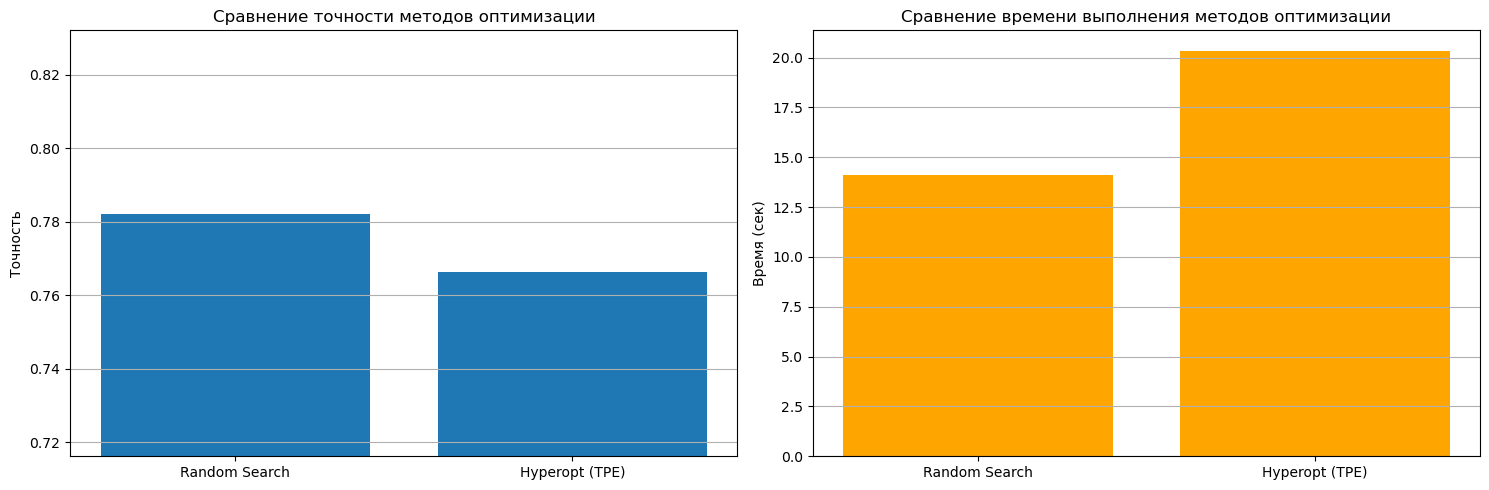

In [45]:
# Визуализация сравнения
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# График точности
ax1.bar(['Random Search', 'Hyperopt (TPE)'], [best_score_random, best_score_hyperopt])
ax1.set_title('Сравнение точности методов оптимизации')
ax1.set_ylabel('Точность')
ax1.set_ylim(min(best_score_random, best_score_hyperopt) - 0.05, 
             max(best_score_random, best_score_hyperopt) + 0.05)
ax1.grid(axis='y')

# График времени выполнения
ax2.bar(['Random Search', 'Hyperopt (TPE)'], [random_search_time, hyperopt_time], color='orange')
ax2.set_title('Сравнение времени выполнения методов оптимизации')
ax2.set_ylabel('Время (сек)')
ax2.grid(axis='y')

plt.tight_layout()
plt.show()